In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import h5py
import scipy
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.motifs import meme
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [3]:
root_dir = "/clusterfs/nilah/pooja"
fig_dir = f"{root_dir}/CellTypeSpecificAccessibilityPrediction/figures"

In [3]:
# PWMs for each JASPAR CORE 2022 motif
pwm_dir = f"/global/scratch/users/poojakathail/motif_databases/JASPAR2022_CORE_vertebrates_non-redundant_v2_pwms/"
tfs = os.listdir(pwm_dir)
tfs = [t.split(".csv")[0] for t in tfs]

pwms = {}
for tf in tfs:
    pwms[tf] = pd.read_csv(f"{pwm_dir}/{tf}.csv", index_col=0, skiprows=1, header=None)
    pwms[tf] = pwms[tf]/pwms[tf].sum(axis=0)  # ensure all columns sum to 1

In [3]:
len(tfs)

791

In [ ]:
motif_data_dir = "/global/scratch/users/poojakathail/kidney_data/archive/scBasset/Homo_sapiens_motif_fasta"

records = list(SeqIO.parse(f"{motif_data_dir}/shuffled_peaks.fasta", "fasta"))
seqs = [str(i.seq) for i in records]

os.mkdir(f"{motif_data_dir}/shuffled_peaks_motifs_JASPAR2022_CORE_vertebrates_non-redundant_v2")

for tf in tfs:        
    motif_seqs = []

    for i in range(len(seqs)):
        # sample motif from PWM
        sampled_motif = pwms[tf].apply(lambda x: np.random.choice(["A", "C", "G","T"], 
                                           p=x, size=1, replace=False), axis=0)
        sampled_motif = ''.join(sampled_motif.values[0])

        # insert motif in center of sequence
        left_coord = int(len(seqs[i])/2) - int(pwms[tf].shape[1]/2)
        motif_seq = seqs[i][:left_coord] + sampled_motif + seqs[i][left_coord+pwms[tf].shape[1]:]
        assert len(motif_seq) == len(seqs[i])
        
        motif_seqs.append(SeqRecord(Seq(motif_seq), id=f"{i}"))

    SeqIO.write(motif_seqs, f"{motif_data_dir}/shuffled_peaks_motifs_JASPAR2022_CORE_vertebrates_non-redundant_v2/{tf}.fasta", "fasta")


Loeb

In [19]:
%%bash

scripts_dir="/clusterfs/nilah/pooja/batch_scripts/test"
motif_activty_script="/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/scripts/tissue_specific_models/tf_motif_activity_scores.py"
motif_data_dir="/global/scratch/users/poojakathail/kidney_data/archive/scBasset/Homo_sapiens_motif_fasta"
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"

model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/kidney_data/targets.txt"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask.json"

cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/kidney_data_multitask_motif_activity.sh 
echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/kidney_data_multitask_motif_activity.sh 
sbatch ${scripts_dir}/kidney_data_multitask_motif_activity.sh 

model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/kidney_data/targets.txt"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask_8x_params_same_layers.json"

cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/kidney_data_multitask_8x_motif_activity.sh 
echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/kidney_data_multitask_8x_motif_activity.sh 
sbatch ${scripts_dir}/kidney_data_multitask_8x_motif_activity.sh 

for cell_type in PT DT LOH Str;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/kidney_data/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_single_task.json"

    cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/kidney_data_single_task_${cell_type}_motif_activity.sh 
    echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/kidney_data_single_task_${cell_type}_motif_activity.sh  
    sbatch ${scripts_dir}/kidney_data_single_task_${cell_type}_motif_activity.sh 
done


Submitted batch job 19256870


Look at results

In [7]:
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"
cell_types = ["PT", "DT", "LOH", "Str"]

tf_activity_scores = {}
tf_activity_scores["Multi-task"] = pd.read_csv(f"{model_dir}/train__multitask__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0)[cell_types]

tf_activity_scores["High capacity multi-task"] = pd.read_csv(f"{model_dir}/train__multitask_8x_params_same_layers__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0)[cell_types]

single_task_df = []
for cell_type in cell_types:
    single_task_df.append(pd.read_csv(f"{model_dir}/train__single_task__{cell_type}__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0))
single_task_df = pd.concat(single_task_df, axis=1)
tf_activity_scores["Single-task"] = single_task_df

40


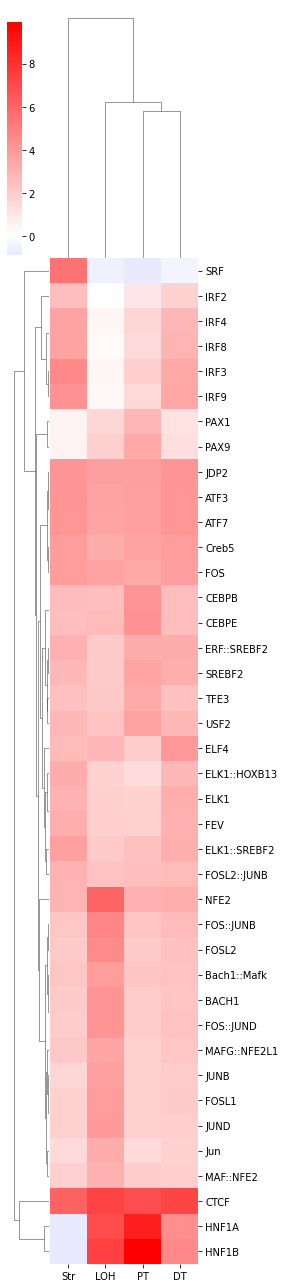

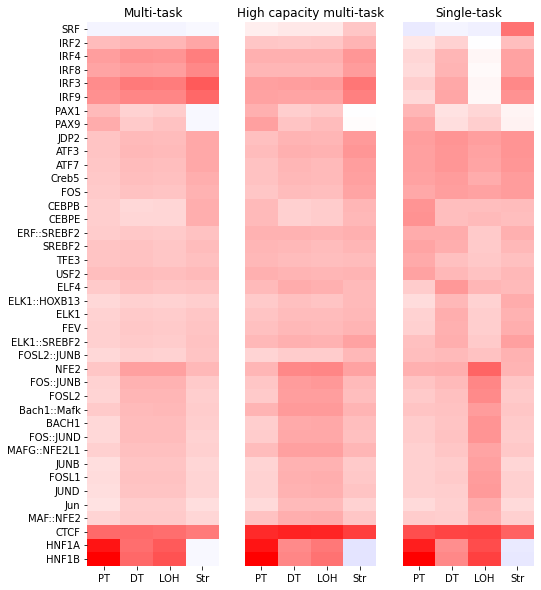

In [11]:
high_activity_tfs = []
for i, model in enumerate(["Multi-task", "High capacity multi-task", "Single-task"]):
    zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
    high_activity_tfs.append(zscore_ordered_df[zscore_ordered_df.abs().max(axis=1) >= 3].index.values)
high_activity_tfs = np.unique(np.concatenate(high_activity_tfs))
print(len(high_activity_tfs))

model = "Single-task"
zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
p = sns.clustermap(zscore_ordered_df.loc[high_activity_tfs], figsize=(4, 18), cmap="bwr", center=0)
order = p.dendrogram_row.reordered_ind

fig, ax = plt.subplots(1, 3, figsize=(8, 10))

for i, model in enumerate(["Multi-task", "High capacity multi-task", "Single-task"]):
    zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
    zscore_ordered_df = zscore_ordered_df.loc[high_activity_tfs]
    zscore_ordered_df = zscore_ordered_df.iloc[order,:]
    sns.heatmap(zscore_ordered_df, cmap="bwr", center=0, cbar=False, ax=ax[i])
    ax[i].set_title(model)
    if i != 0:
        ax[i].set_yticks([])
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_tf_activity_single_multi_task_high_capacity.pdf", dpi=300)

Calderon

In [15]:
%%bash

scripts_dir="/clusterfs/nilah/pooja/batch_scripts/test"
motif_activty_script="/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/scripts/tissue_specific_models/tf_motif_activity_scores.py"
motif_data_dir="/global/scratch/users/poojakathail/kidney_data/archive/scBasset/Homo_sapiens_motif_fasta"
model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"

model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/immune_atlas/targets.txt"
params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_multitask.json"

cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/immune_atlas_multitask_motif_activity.sh 
echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/immune_atlas_multitask_motif_activity.sh 
sbatch ${scripts_dir}/immune_atlas_multitask_motif_activity.sh 

model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/immune_atlas/targets.txt"
params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_multitask_8x_params_same_layers.json"

cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/immune_atlas_multitask_8x_motif_activity.sh 
echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/immune_atlas_multitask_8x_motif_activity.sh 
sbatch ${scripts_dir}/immune_atlas_multitask_8x_motif_activity.sh 

for cell_type in DCmye NKim TCD8EM;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/immune_atlas/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_single_task.json"

    cp ${scripts_dir}/test_motif_activity_template.sh ${scripts_dir}/immune_atlas_single_task_${cell_type}_motif_activity.sh 
    echo "python ${motif_activty_script} --rc --shifts -1,0,1 -o ${model_dir}/${model} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${motif_data_dir}" >> ${scripts_dir}/immune_atlas_single_task_${cell_type}_motif_activity.sh  
    sbatch ${scripts_dir}/immune_atlas_single_task_${cell_type}_motif_activity.sh 
done


Submitted batch job 19256109


Look at results

In [12]:
model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"
cell_types = ["DCmye", "NKim", "TCD8EM"]
cell_types = ["DCmye", "TCD8EM"]

tf_activity_scores = {}
tf_activity_scores["Multi-task"] = pd.read_csv(f"{model_dir}/train__multitask__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0)[cell_types]

tf_activity_scores["High capacity multi-task"] = pd.read_csv(f"{model_dir}/train__multitask_8x_params_same_layers__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0)[cell_types]

single_task_df = []
for cell_type in cell_types:
    single_task_df.append(pd.read_csv(f"{model_dir}/train__single_task__{cell_type}__all_sequences__1/tf_activity_scores.tsv",
                                              sep="\t", index_col=0))
single_task_df = pd.concat(single_task_df, axis=1)
tf_activity_scores["Single-task"] = single_task_df

30


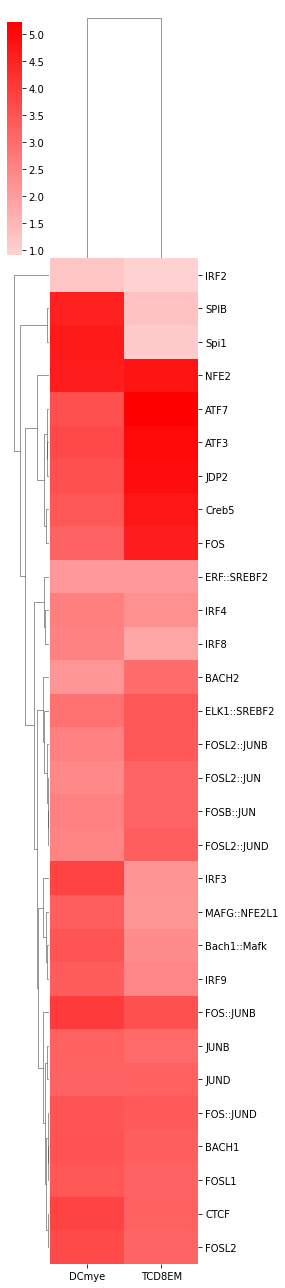

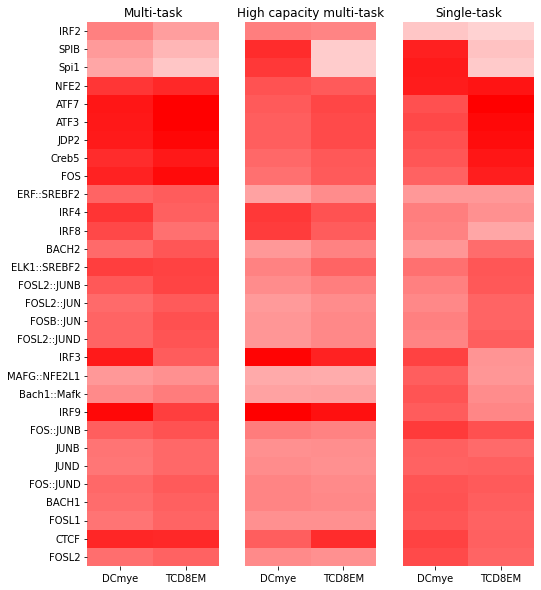

In [16]:
high_activity_tfs = []
for i, model in enumerate(["Multi-task", "High capacity multi-task", "Single-task"]):
    zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
    high_activity_tfs.append(zscore_ordered_df[zscore_ordered_df.abs().max(axis=1) >= 3].index.values)
high_activity_tfs = np.unique(np.concatenate(high_activity_tfs))
print(len(high_activity_tfs))

model = "Single-task"
zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
p = sns.clustermap(zscore_ordered_df.loc[high_activity_tfs], figsize=(4, 18), cmap="bwr", center=0)
order = p.dendrogram_row.reordered_ind

fig, ax = plt.subplots(1, 3, figsize=(8, 10))

for i, model in enumerate(["Multi-task", "High capacity multi-task", "Single-task"]):
    zscore_ordered_df = (tf_activity_scores[model] - tf_activity_scores[model].mean(axis=0))/tf_activity_scores[model].std(axis=0)
    zscore_ordered_df = zscore_ordered_df.loc[high_activity_tfs]
    zscore_ordered_df = zscore_ordered_df.iloc[order,:]
    sns.heatmap(zscore_ordered_df, cmap="bwr", center=0, cbar=False, ax=ax[i])
    ax[i].set_title(model)
    if i != 0:
        ax[i].set_yticks([])
plt.savefig(f"{fig_dir}/supp_figs/calderon_et_al_tf_activity_single_multi_task_high_capacity.pdf", dpi=300)

## Locus specific ISM

In [6]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/test"
dataset="kidney_data"
genome_fasta="/clusterfs/nilah/pooja/genomes/hg38.ml.fa"
model_dir="/clusterfs/nilah/pooja/${dataset}/train/replicate_models"
clusters_dir="/clusterfs/nilah/pooja/${dataset}/CellTypeSpecificPeakClusters_ArchR_clust11"

# multi task
model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/${dataset}/targets.txt"
params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_multitask_512_batch.json"

for bed_prefix in Str_peaks_multitask_false_positive_in_PT PT_peaks_multitask_false_positive_in_Str;
do
    cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_all_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}_all.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
done

# high capacity multi task
model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/${dataset}/targets.txt"
params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_multitask_8x_params_same_layers_512_batch.json"

for bed_prefix in Str_peaks_multitask_false_positive_in_PT PT_peaks_multitask_false_positive_in_Str;
do
    cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
done

# single task
for cell_type in PT DT LOH Str;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/${dataset}/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_single_task_512_batch.json"

    for bed_prefix in Str_peaks_multitask_false_positive_in_PT PT_peaks_multitask_false_positive_in_Str;
    do
        cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
        echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_all_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}_all.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
        sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    done
done

Submitted batch job 19191019
Submitted batch job 19191020


In [39]:
from basenji import plots
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"

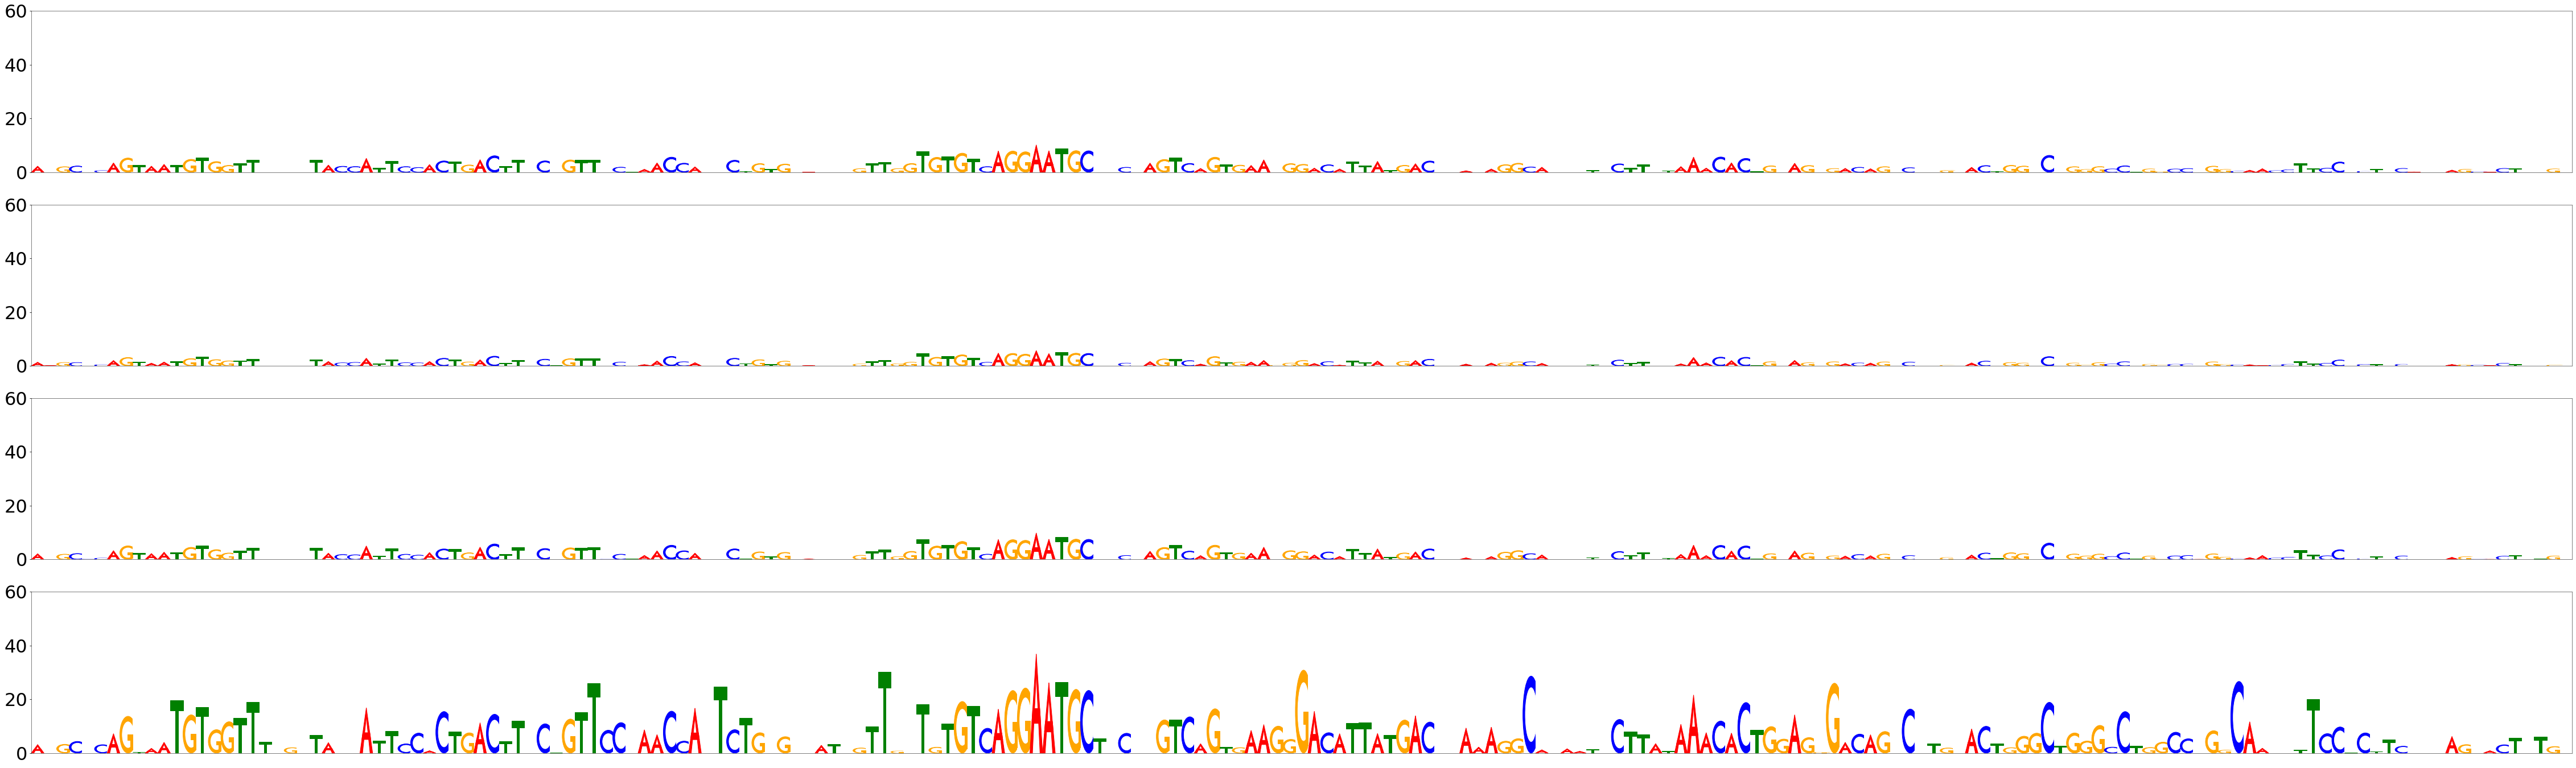

In [52]:
model="train__multitask__all_sequences__1"

for bed_prefix in ["Str_peaks_multitask_false_positive_in_PT"]:
    scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

    for si in [0]:
        # read sequence
        seq_1hot = scores_h5['seqs'][si,:]

        # read scores
        scores = scores_h5['sum'][si,:,:,:]

        # reference scores
        ref_scores = scores[seq_1hot]

        fig, ax = plt.subplots(4,1, figsize=(80,24))
        for i, ti in enumerate([9,8,7,1]):
            scores_ti = scores[:,:,ti]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[ti]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)

            if bed_prefix.startswith("Str") and si == 0:
                plot_range=np.arange(650,850)
                ymax = 60

            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/Str_peaks_multitask_false_positive_in_PT_multi_task_model_seq0_y{ymax}.pdf", dpi=300)

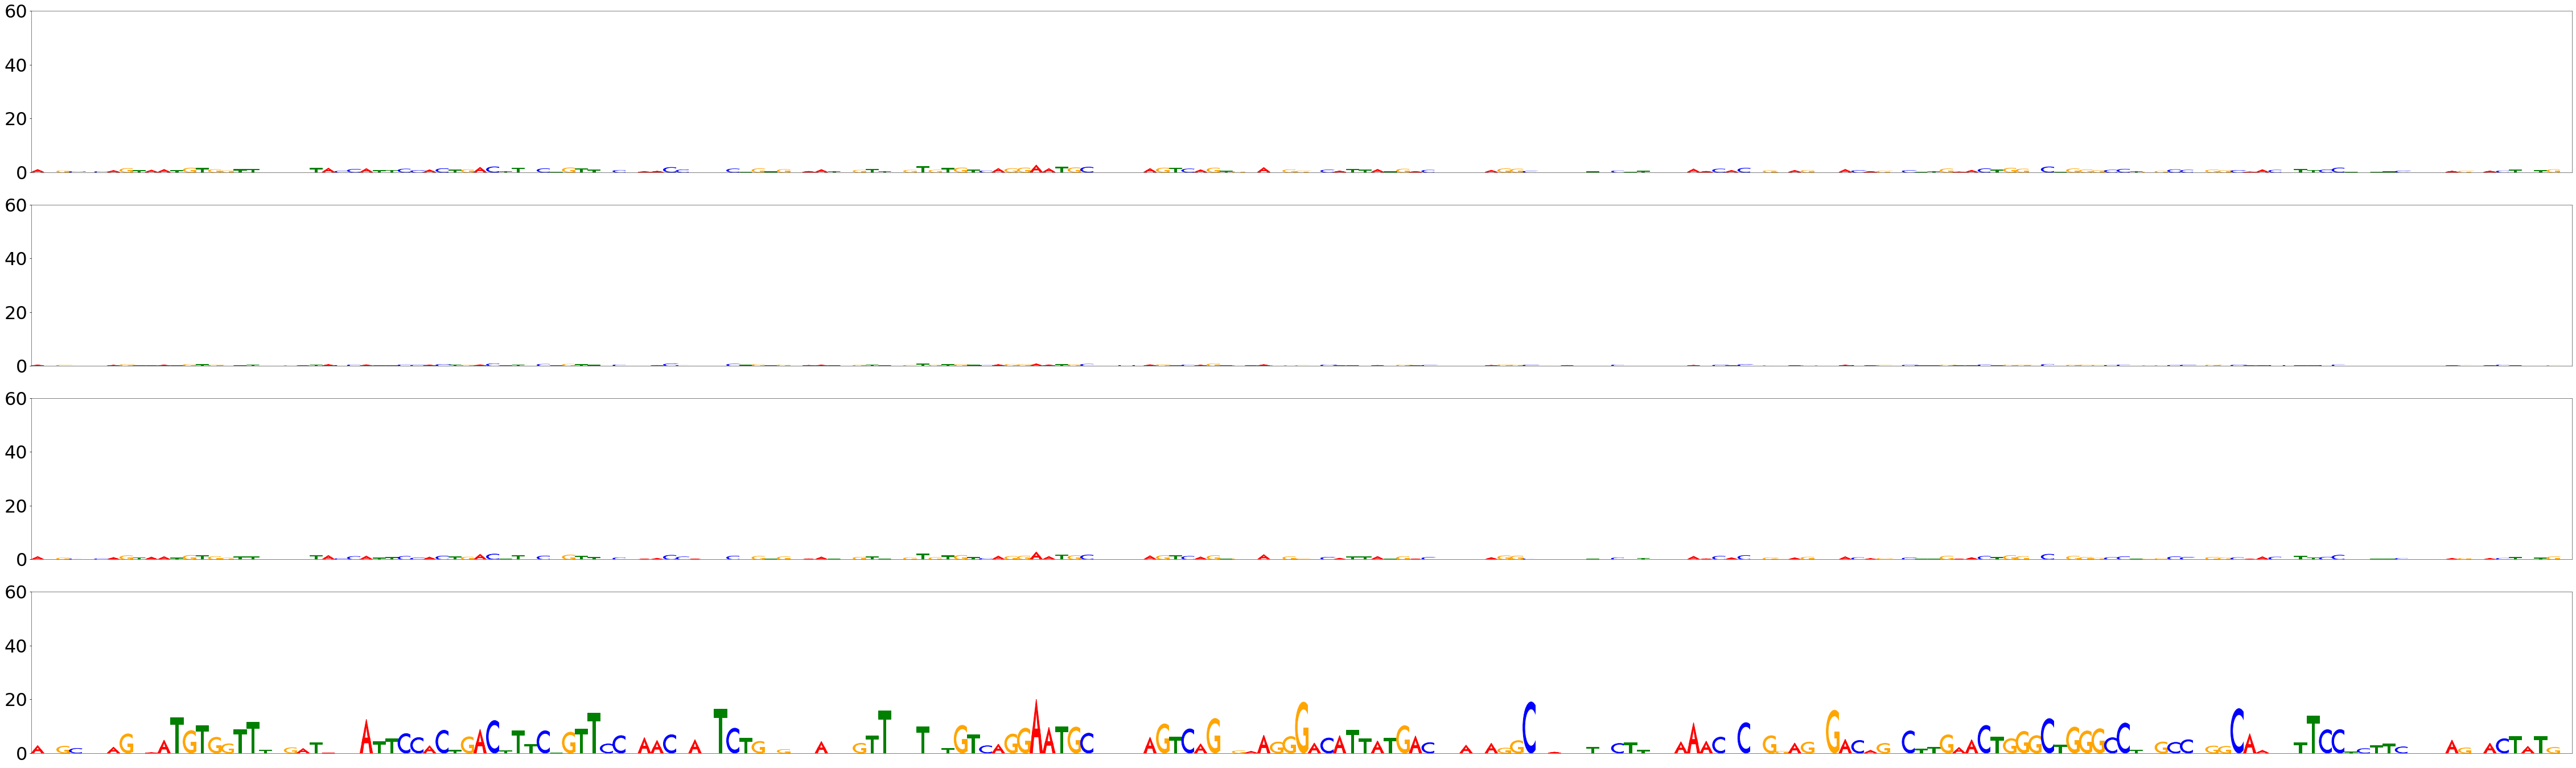

In [51]:
model="train__multitask_8x_params_same_layers__all_sequences__1"

for bed_prefix in ["Str_peaks_multitask_false_positive_in_PT"]:
    scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

    for si in [0]:
        # read sequence
        seq_1hot = scores_h5['seqs'][si,:]

        # read scores
        scores = scores_h5['sum'][si,:,:,:]

        # reference scores
        ref_scores = scores[seq_1hot]

        fig, ax = plt.subplots(4,1, figsize=(80,24))
        for i, ti in enumerate([9,8,7,1]):
            scores_ti = scores[:,:,ti]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[ti]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)

            if bed_prefix.startswith("Str") and si == 0:
                plot_range=np.arange(650,850)
                ymax = 60
           
            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/Str_peaks_multitask_false_positive_in_PT_multi_task_8x_model_seq0_y{ymax}.pdf", dpi=300)

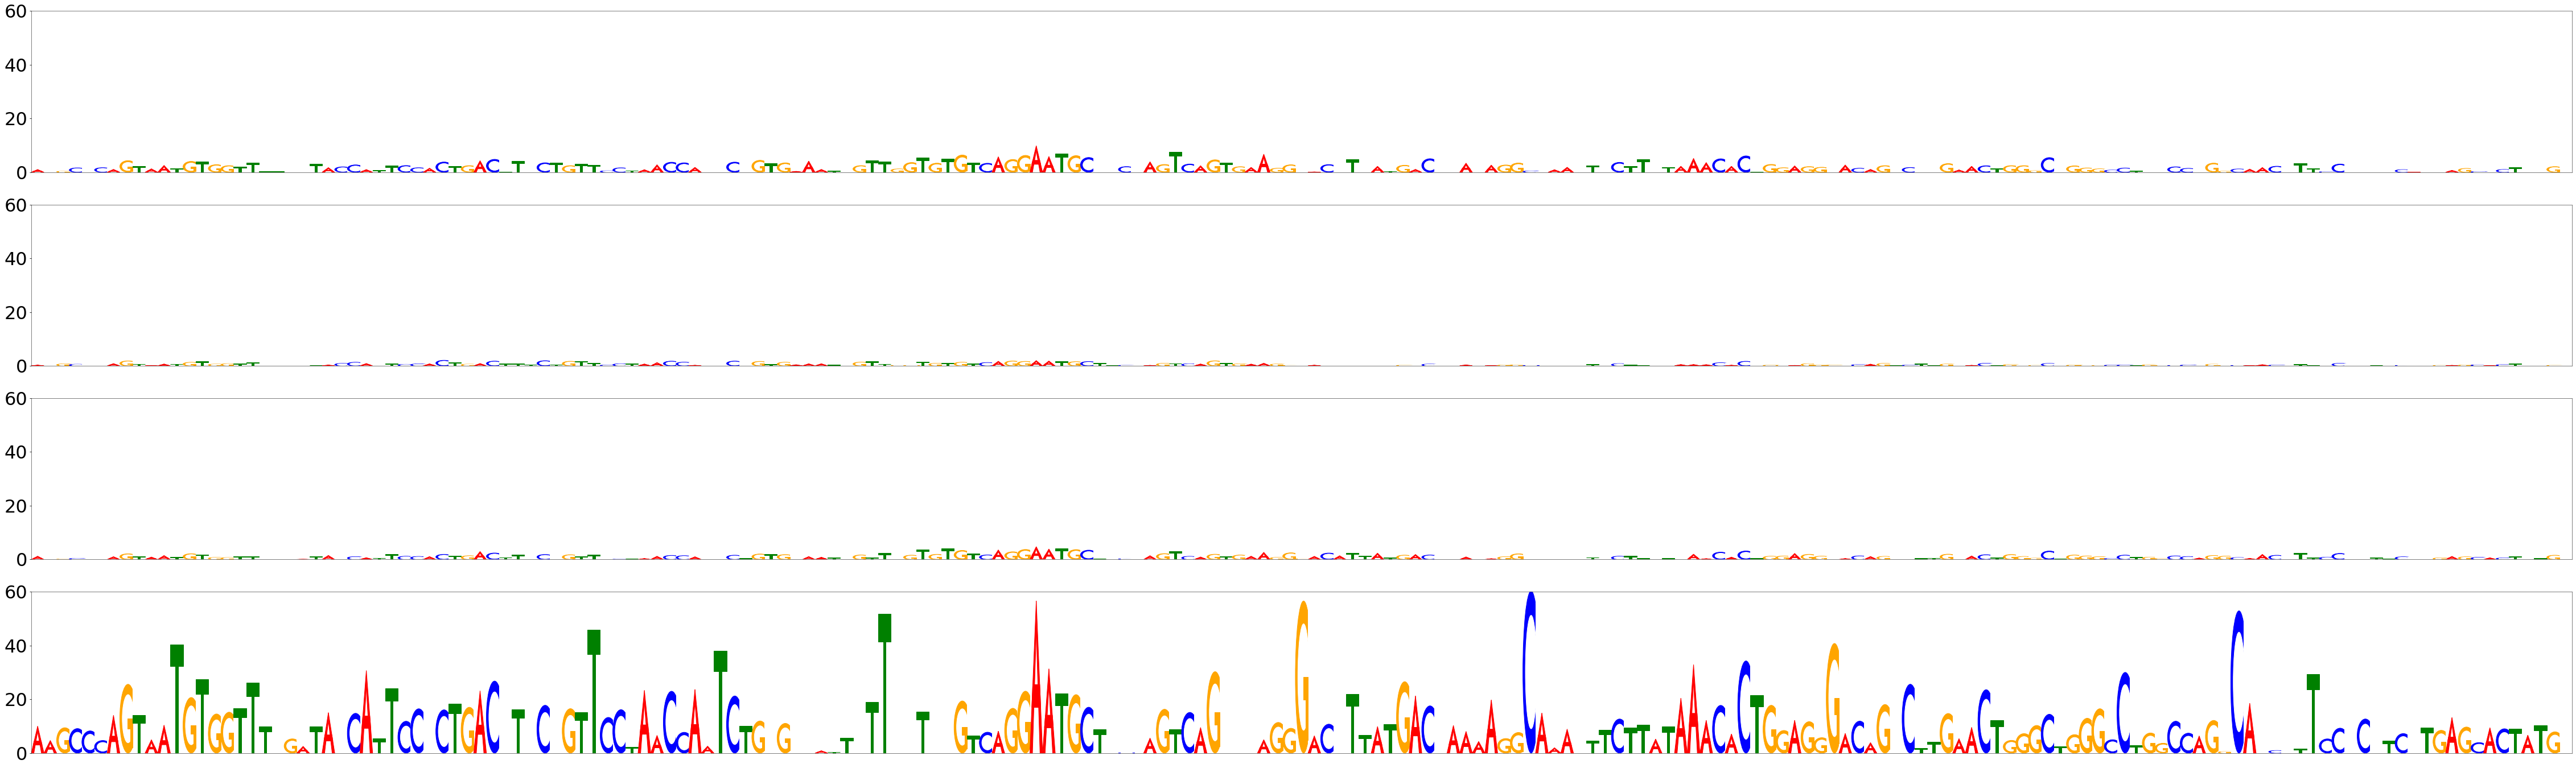

In [53]:
for bed_prefix in ["Str_peaks_multitask_false_positive_in_PT"]:
    for si in [0]:
        fig, ax = plt.subplots(4,1, figsize=(80,24))

        for i, cell_type in enumerate(["LOH", "PT", "DT", "Str"]):
            model=f"train__single_task__{cell_type}__all_sequences__1"
            scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

            # read sequence
            seq_1hot = scores_h5['seqs'][si,:]

            # read scores
            scores = scores_h5['sum'][si,:,:,:]

            # reference scores
            ref_scores = scores[seq_1hot]

            scores_ti = scores[:,:,0]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[0]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)

            if bed_prefix.startswith("Str") and si == 0:
                plot_range=np.arange(650,850)
                ymax = 60
           
            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/Str_peaks_multitask_false_positive_in_PT_single_task_model_seq0_y{ymax}.pdf", dpi=300)

In [7]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/test"
dataset="immune_atlas"
genome_fasta="/clusterfs/nilah/pooja/genomes/hg19.ml.fa"
model_dir="/clusterfs/nilah/pooja/${dataset}/train/replicate_models"
clusters_dir="/clusterfs/nilah/pooja/${dataset}/CellTypeSpecificPeakClusters"

# multi task
model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/${dataset}/targets.txt"
params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_multitask_512_batch.json"

for bed_prefix in DCmye_peaks_multitask_false_positive_in_TCD8EM TCD8EM_peaks_multitask_false_positive_in_DCmye;
do
    cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_all_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}_all.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
done

# high capacity multi task
model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/${dataset}/targets.txt"
params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_multitask_8x_params_same_layers_512_batch.json"

for bed_prefix in DCmye_peaks_multitask_false_positive_in_TCD8EM TCD8EM_peaks_multitask_false_positive_in_DCmye;
do
    cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
done

# single task
for cell_type in DCmye NKim TCD8EM;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/${dataset}/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/${dataset}/models/params_sc_kidney_regression_single_task_512_batch.json"

    for bed_prefix in DCmye_peaks_multitask_false_positive_in_TCD8EM TCD8EM_peaks_multitask_false_positive_in_DCmye;
    do
        cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
        echo "python /global/home/users/poojakathail/basenji/bin/basenji_sat_bed.py -f ${genome_fasta} -l 1344 --rc --shifts -1,0,1 -t ${targets} -o ${model_dir}/${model}/${bed_prefix}_all_ism ${params} ${model_dir}/${model}/model_best.h5 ${clusters_dir}/${bed_prefix}_all.bed" >> ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
        sbatch ${script_dir}/sat_bed_${model}_${bed_prefix}.sh
    done
done

Submitted batch job 19191023
Submitted batch job 19191024


In [54]:
model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"

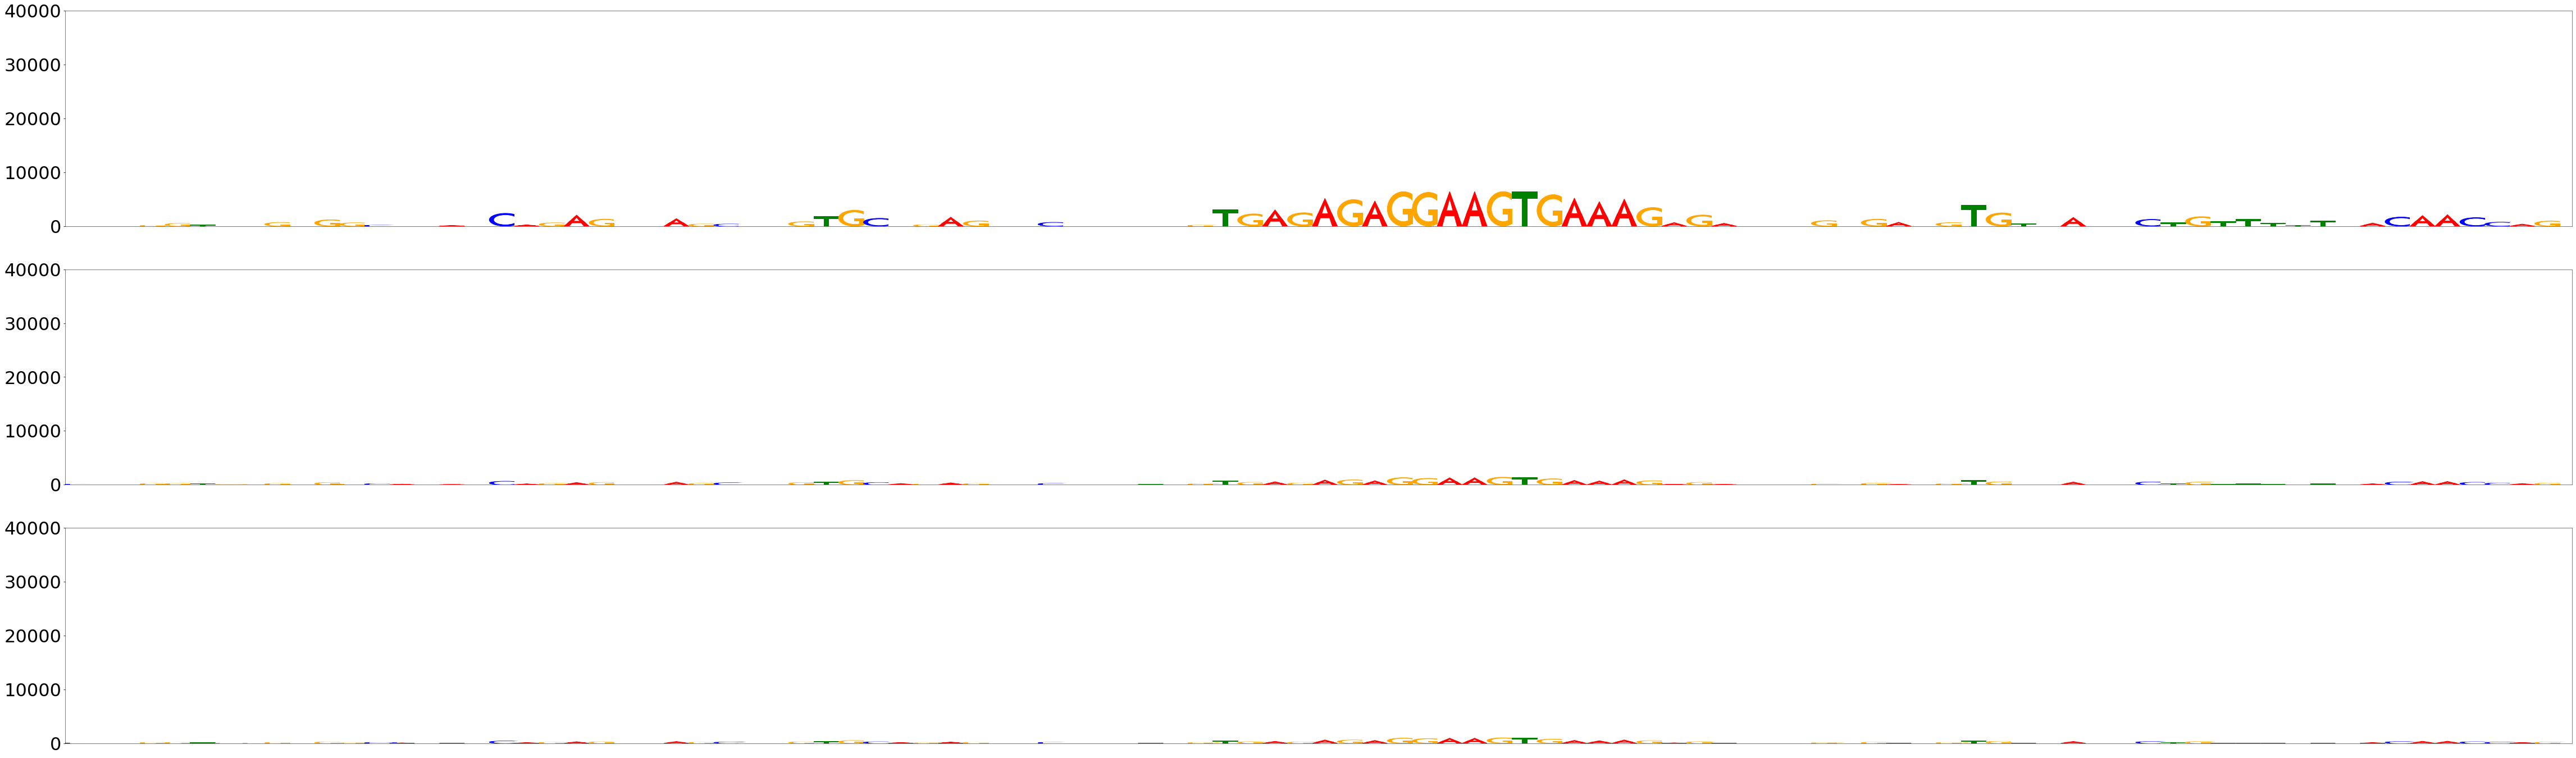

In [55]:
model="train__multitask__all_sequences__1"

for bed_prefix in ["DCmye_peaks_multitask_false_positive_in_TCD8EM"]:
    scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

    for si in [1]:
        # read sequence
        seq_1hot = scores_h5['seqs'][si,:]

        # read scores
        scores = scores_h5['sum'][si,:,:,:]

        # reference scores
        ref_scores = scores[seq_1hot]

        fig, ax = plt.subplots(3,1, figsize=(80,24))
        for i, ti in enumerate([3, 21, 5]):
            scores_ti = scores[:,:,ti]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[ti]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)

            if bed_prefix.startswith("DCmye") and si == 1:
                plot_range=np.arange(600,700)
                ymax=40_000

            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/DCmye_peaks_multitask_false_positive_in_TCD8EM_multi_task_model_seq1_y{ymax}.pdf", dpi=300)

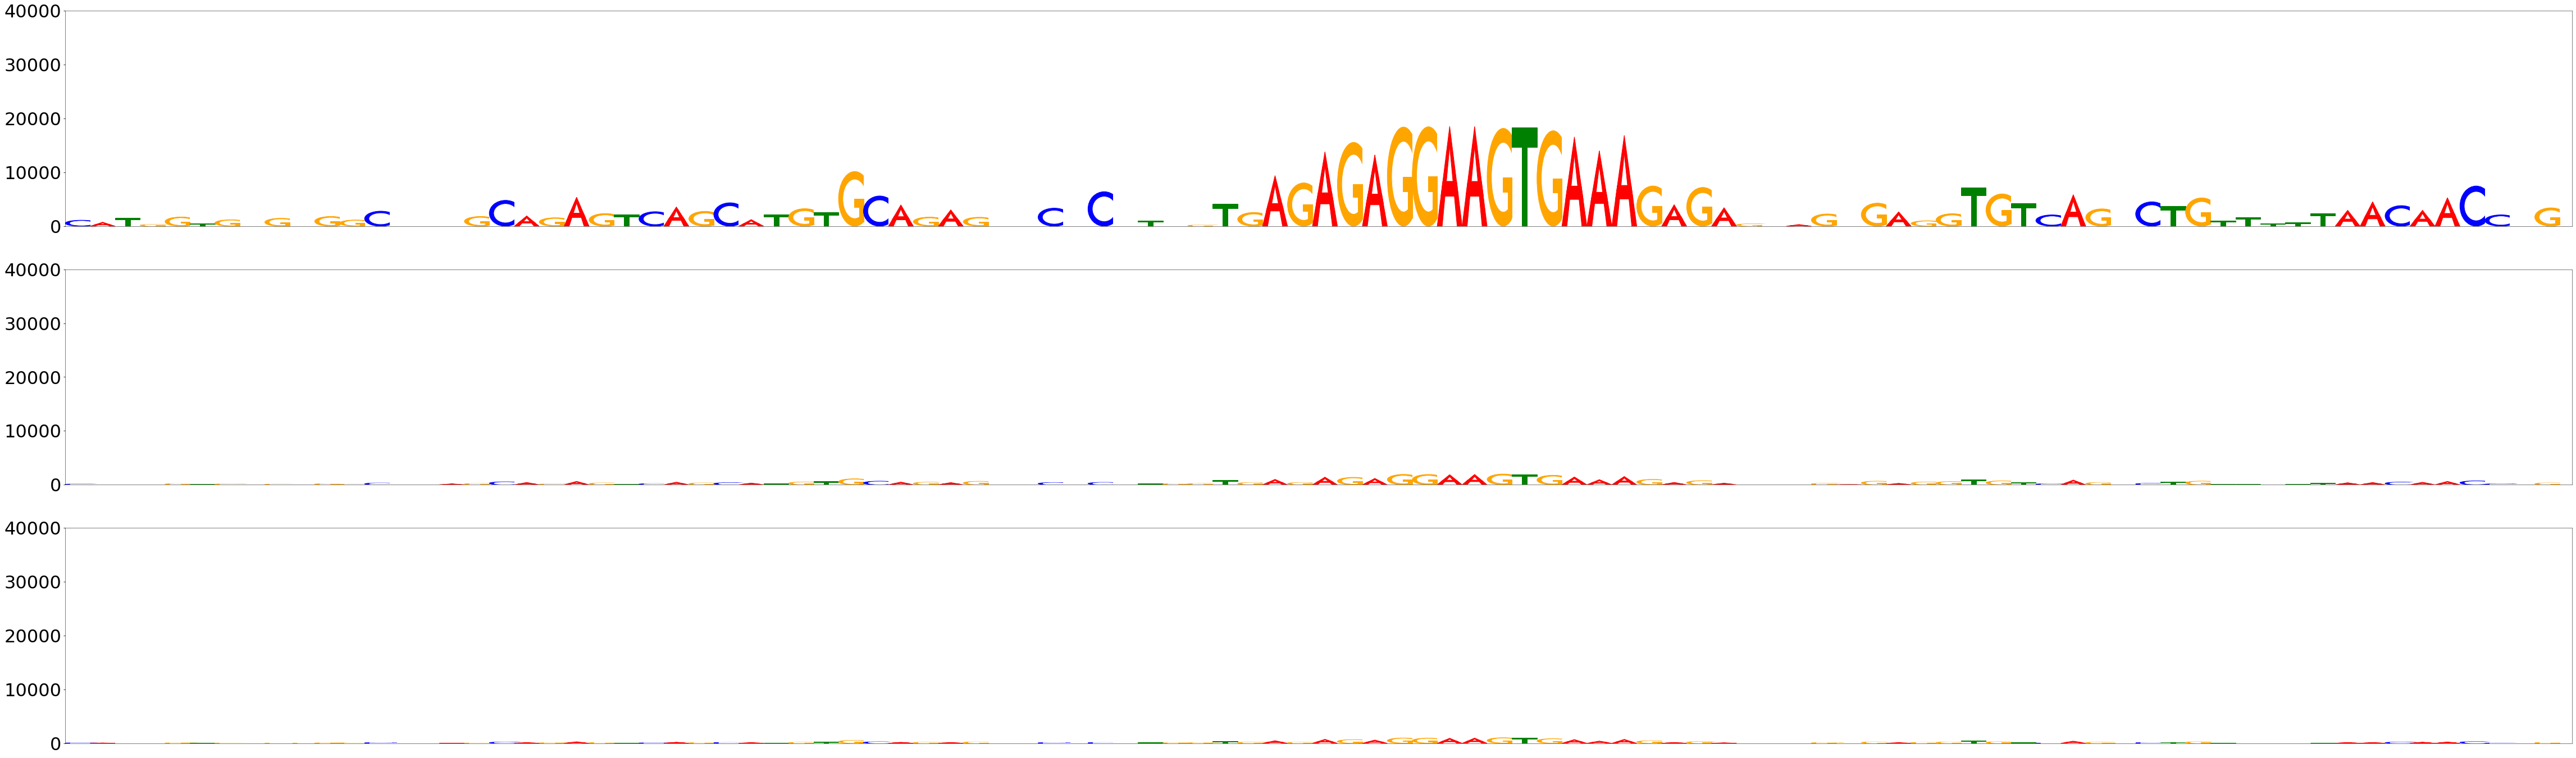

In [56]:
model="train__multitask_8x_params_same_layers__all_sequences__1"

for bed_prefix in ["DCmye_peaks_multitask_false_positive_in_TCD8EM"]:
    scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

    for si in [1]:
        # read sequence
        seq_1hot = scores_h5['seqs'][si,:]

        # read scores
        scores = scores_h5['sum'][si,:,:,:]

        # reference scores
        ref_scores = scores[seq_1hot]

        fig, ax = plt.subplots(3,1, figsize=(80,24))
        for i, ti in enumerate([3, 21, 5]):
            scores_ti = scores[:,:,ti]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[ti]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)

            if bed_prefix.startswith("DCmye") and si == 1:
                plot_range=np.arange(600,700)
                ymax=40_000

            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/DCmye_peaks_multitask_false_positive_in_TCD8EM_multi_task_8x_model_seq1_y{ymax}.pdf", dpi=300)

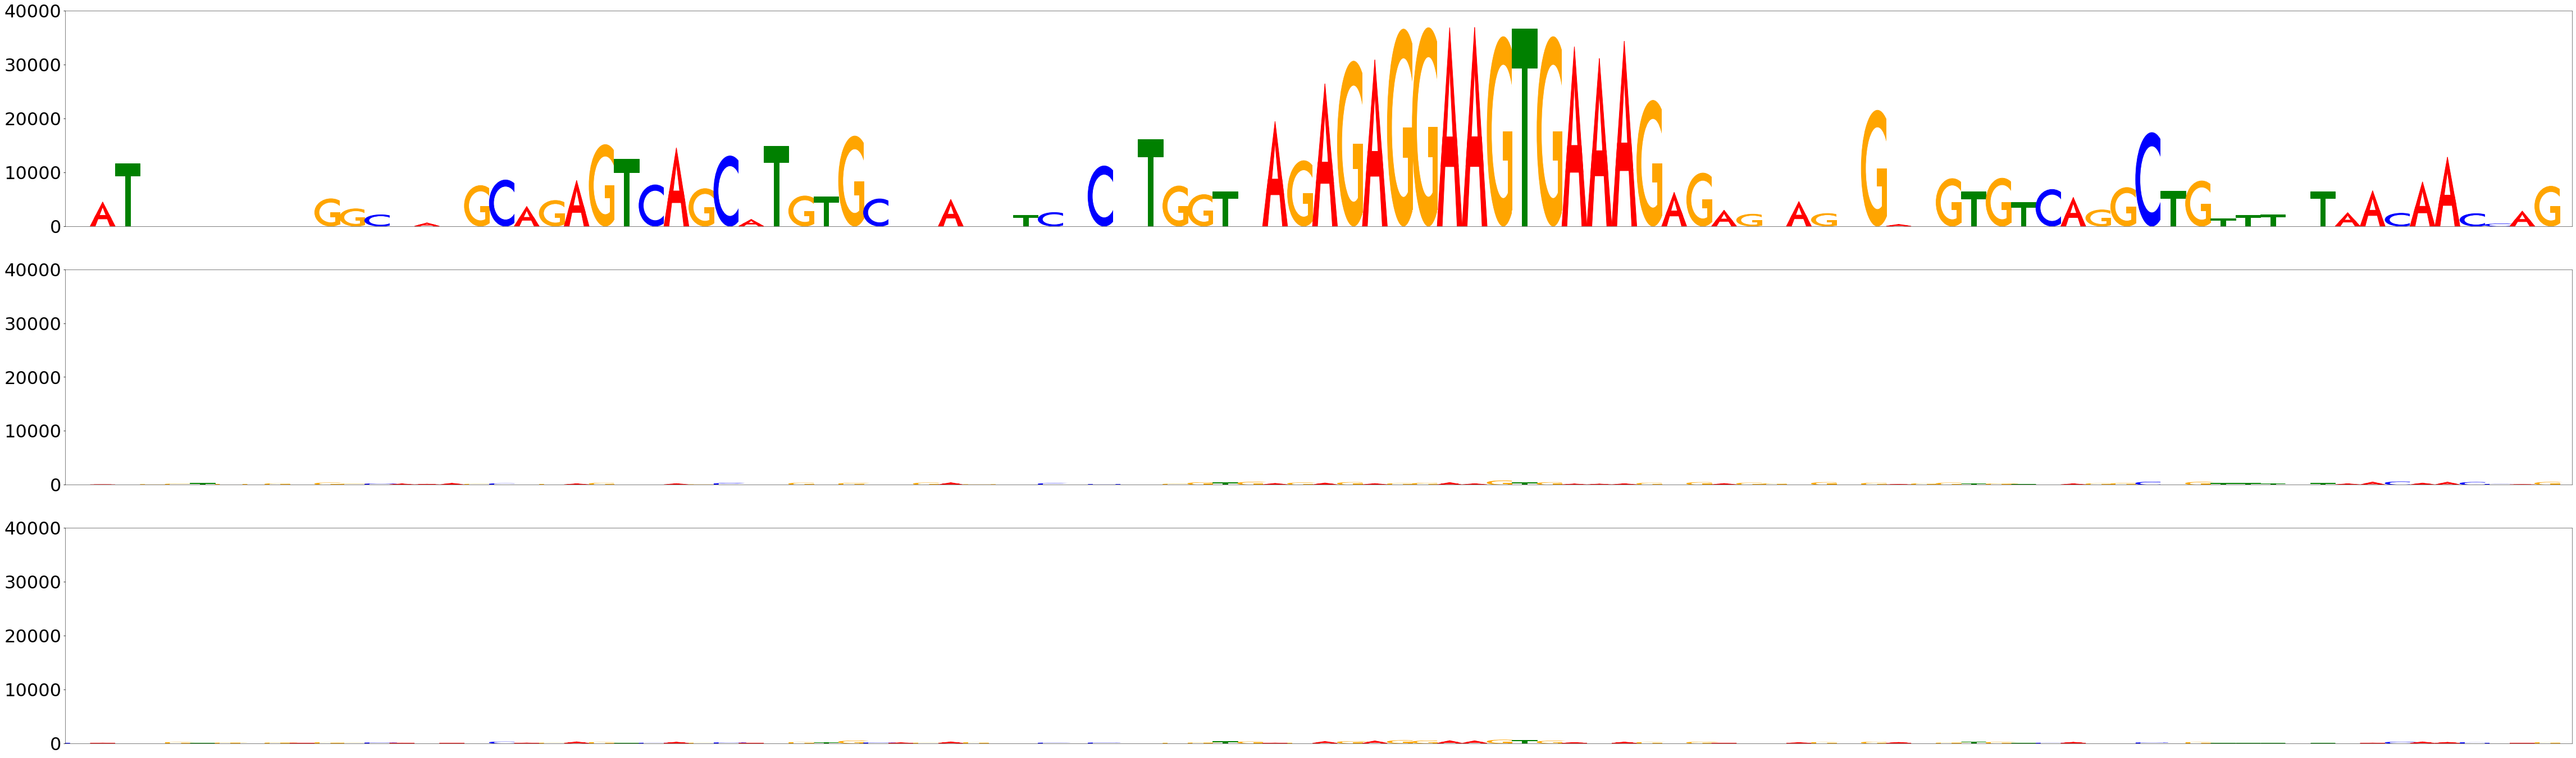

In [57]:
for bed_prefix in ["DCmye_peaks_multitask_false_positive_in_TCD8EM"]:
    for si in [1]:
        fig, ax = plt.subplots(3,1, figsize=(80,24))

        for i, cell_type in enumerate(["DCmye", "NKim", "TCD8EM"]):
            model=f"train__single_task__{cell_type}__all_sequences__1"
            scores_h5 = h5py.File(f"{model_dir}/{model}/{bed_prefix}_ism/scores.h5", "r")

            # read sequence
            seq_1hot = scores_h5['seqs'][si,:]

            # read scores
            scores = scores_h5['sum'][si,:,:,:]

            # reference scores
            ref_scores = scores[seq_1hot]

            scores_ti = scores[:,:,0]

            # compute scores relative to reference
            delta_ti = scores_ti - ref_scores[:,[0]]

            # compute loss and gain
            delta_loss = delta_ti.min(axis=1)
            delta_gain = delta_ti.max(axis=1)

            sat_score_cp = -delta_loss.copy()

            # tile loss scores to align
            sat_lg_tile = np.tile(sat_score_cp, (4, 1)).T

            # element-wise multiple
            at_lg_4l = np.multiply(seq_1hot, sat_lg_tile)   
            
            if bed_prefix.startswith("DCmye") and si == 1:
                plot_range=np.arange(600,700)
                ymax=40_000  
                
            plots.seqlogo(at_lg_4l[plot_range,:], ax=ax[i])
            ax[i].set_ylim(0, ymax)
            ax[i].set_ylabel("ISM", fontsize=60)
            ax[i].set_xticks([])
            ax[i].tick_params(axis='both', which='major', labelsize=32)
        plt.savefig(f"{fig_dir}/supp_figs/DCmye_peaks_multitask_false_positive_in_TCD8EM_single_task_model_seq1_y{ymax}.pdf", dpi=300)

## TF-modisco

In [ ]:
%%sh
pip install modisco-lite --user

In [30]:
%%sh
wget --quiet \
https://jaspar.genereg.net/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt \
-O /global/scratch/users/poojakathail/motif_databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt

### Run TF-MoDISco on peaks from each cluster

In [18]:
%%bash
# Step 1. Get model attributions for the peaks in each cluster

script_dir="/clusterfs/nilah/pooja/batch_scripts/test"
dataset="kidney_data"
genome_fasta="/clusterfs/nilah/pooja/genomes/hg38.ml.fa"
model_dir="/clusterfs/nilah/pooja/${dataset}/train/replicate_models"
clusters_dir="/clusterfs/nilah/pooja/${dataset}/CellTypeSpecificPeakClusters_ArchR_clust11"

for model in train__multitask__all_sequences train__single_task__LOH__all_sequences train__single_task__PT__all_sequences train__single_task__DT__all_sequences train__single_task__Str__all_sequences train__multitask_8x_params_same_layers__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster3_Ubiquitous cluster11_PT cluster4_DistalNephron cluster9_Stroma;
        do
            cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
            echo "python /global/home/users/poojakathail/basenji/bin/basenji_attributions.py -n 10000 -f ${genome_fasta} -c ${cluster}_10000 --rc --shifts -1,0,1 ${model_dir}/${model}__${rep} ${clusters_dir}/${cluster}.bed" >> ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
            sbatch ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
        done
    done
done

Submitted batch job 19256301
Submitted batch job 19256302
Submitted batch job 19256303
Submitted batch job 19256304
Submitted batch job 19256305
Submitted batch job 19256306
Submitted batch job 19256307
Submitted batch job 19256308
Submitted batch job 19256309
Submitted batch job 19256310
Submitted batch job 19256311
Submitted batch job 19256312
Submitted batch job 19256313
Submitted batch job 19256314
Submitted batch job 19256315
Submitted batch job 19256316
Submitted batch job 19256317
Submitted batch job 19256318
Submitted batch job 19256319
Submitted batch job 19256320
Submitted batch job 19256321
Submitted batch job 19256322
Submitted batch job 19256323
Submitted batch job 19256324
Submitted batch job 19256325
Submitted batch job 19256326
Submitted batch job 19256327
Submitted batch job 19256328
Submitted batch job 19256329
Submitted batch job 19256330
Submitted batch job 19256331
Submitted batch job 19256332
Submitted batch job 19256333
Submitted batch job 19256334
Submitted batc

In [17]:
%%bash
# Step 1. Get model attributions for the peaks in each cluster

script_dir="/clusterfs/nilah/pooja/batch_scripts/test"
dataset="immune_atlas"
genome_fasta="/clusterfs/nilah/pooja/genomes/hg19.ml.fa"
model_dir="/clusterfs/nilah/pooja/${dataset}/train/replicate_models"
clusters_dir="/clusterfs/nilah/pooja/${dataset}/CellTypeSpecificPeakClusters"

for model in train__multitask__all_sequences train__single_task__DCmye__all_sequences train__single_task__NKim__all_sequences train__single_task__TCD8EM__all_sequences train__multitask_8x_params_same_layers__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster_open_500bp cluster_myeloid_resting_500bp cluster_nk_resting_500bp cluster_T_resting_500bp;
        do
            cp ${script_dir}/enformer_pred_eqtl_vcf_template.sh ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
            echo "python /global/home/users/poojakathail/basenji/bin/basenji_attributions.py -n 6104 -f ${genome_fasta} -c ${cluster}_6104 --rc --shifts -1,0,1 ${model_dir}/${model}__${rep} ${clusters_dir}/${cluster}.bed" >> ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
            sbatch ${script_dir}/gradient_attributions_${dataset}_${model}__${rep}_${cluster}.sh
        done
    done
done

Submitted batch job 19256241
Submitted batch job 19256242
Submitted batch job 19256243
Submitted batch job 19256244
Submitted batch job 19256245
Submitted batch job 19256246
Submitted batch job 19256247
Submitted batch job 19256248
Submitted batch job 19256249
Submitted batch job 19256250
Submitted batch job 19256251
Submitted batch job 19256252
Submitted batch job 19256253
Submitted batch job 19256254
Submitted batch job 19256255
Submitted batch job 19256256
Submitted batch job 19256257
Submitted batch job 19256258
Submitted batch job 19256259
Submitted batch job 19256260
Submitted batch job 19256261
Submitted batch job 19256262
Submitted batch job 19256263
Submitted batch job 19256264
Submitted batch job 19256265
Submitted batch job 19256266
Submitted batch job 19256267
Submitted batch job 19256268
Submitted batch job 19256269
Submitted batch job 19256270
Submitted batch job 19256271
Submitted batch job 19256272
Submitted batch job 19256273
Submitted batch job 19256274
Submitted batc

In [113]:
%%bash

# Step 2. Run TF-MoDISCO using the attributions computed in Step 1.

script_dir="/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/scripts/tissue_specific_models"
export PATH="/global/home/users/poojakathail/.local/bin:$PATH"
module load meme/4.12.0
meme_db="/global/scratch/users/poojakathail/motif_databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt"
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"

for model in train__multitask__all_sequences train__multitask_8x_params_same_layers__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster3_Ubiquitous cluster11_PT cluster4_DistalNephron cluster9_Stroma;
        do
            for ti in 1 7 8 9;
            do
                for n in 10000 34129;
                do
                    cp ${script_dir}/run_tf_modisco_template.sh ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                    echo "modisco motifs --window 1344 -s ${model_dir}/${model}__${rep}/${cluster}_${n}_one_hot_seqs.npy -a ${model_dir}/${model}__${rep}/${cluster}_${n}_inputxgradient_ti_${ti}.npy -n 2000 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                    echo "modisco report -i ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti} -m ${meme_db}" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                    sbatch ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                done
            done
        done
    done
done

ti=0
for model in train__single_task__LOH__all_sequences train__single_task__PT__all_sequences train__single_task__DT__all_sequences train__single_task__Str__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster3_Ubiquitous cluster11_PT cluster4_DistalNephron cluster9_Stroma;
        do 
            for n in 10000 34129;
            do
                cp ${script_dir}/run_tf_modisco_template.sh ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                echo "modisco motifs --window 1344 -s ${model_dir}/${model}__${rep}/${cluster}_${n}_one_hot_seqs.npy -a ${model_dir}/${model}__${rep}/${cluster}_${n}_inputxgradient_ti_${ti}.npy -n 2000 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                echo "modisco report -i ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti} -m ${meme_db}" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                sbatch ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
            done
        done
    done
done

Submitted batch job 19327633
Submitted batch job 19327635
Submitted batch job 19327637
Submitted batch job 19327639
Submitted batch job 19327641
Submitted batch job 19327643
Submitted batch job 19327645
Submitted batch job 19327647
Submitted batch job 19327648
Submitted batch job 19327651
Submitted batch job 19327653
Submitted batch job 19327655
Submitted batch job 19327657
Submitted batch job 19327659
Submitted batch job 19327661
Submitted batch job 19327663
Submitted batch job 19327665
Submitted batch job 19327667
Submitted batch job 19327669
Submitted batch job 19327670
Submitted batch job 19327673
Submitted batch job 19327675
Submitted batch job 19327677
Submitted batch job 19327679
Submitted batch job 19327680
Submitted batch job 19327683
Submitted batch job 19327685
Submitted batch job 19327687
Submitted batch job 19327688
Submitted batch job 19327689
Submitted batch job 19327690
Submitted batch job 19327691
Submitted batch job 19327692
Submitted batch job 19327693
Submitted batc

In [114]:
%%bash

# Step 2. Run TF-MoDISCO using the attributions computed in Step 1.

script_dir="/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/scripts/tissue_specific_models"
export PATH="/global/home/users/poojakathail/.local/bin:$PATH"
module load meme/4.12.0
meme_db="/global/scratch/users/poojakathail/motif_databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt"
model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"
n="6104"

for model in train__multitask__all_sequences train__multitask_8x_params_same_layers__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster_open_500bp cluster_myeloid_resting_500bp cluster_nk_resting_500bp cluster_T_resting_500bp;
        do
            for ti in 3 5 21;
            do
                cp ${script_dir}/run_tf_modisco_template.sh ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                echo "modisco motifs --window 1344 -s ${model_dir}/${model}__${rep}/${cluster}_${n}_one_hot_seqs.npy -a ${model_dir}/${model}__${rep}/${cluster}_${n}_inputxgradient_ti_${ti}.npy -n 2000 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                echo "modisco report -i ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti} -m ${meme_db}" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
                sbatch ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
            done
        done
    done
done

ti=0
for model in train__single_task__DCmye__all_sequences train__single_task__NKim__all_sequences train__single_task__TCD8EM__all_sequences;
do
    for rep in 1 2 3;
    do
        for cluster in cluster_open_500bp cluster_myeloid_resting_500bp cluster_nk_resting_500bp cluster_T_resting_500bp;
        do
            cp ${script_dir}/run_tf_modisco_template.sh ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
            echo "modisco motifs --window 1344 -s ${model_dir}/${model}__${rep}/${cluster}_${n}_one_hot_seqs.npy -a ${model_dir}/${model}__${rep}/${cluster}_${n}_inputxgradient_ti_${ti}.npy -n 2000 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
            echo "modisco report -i ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti}.h5 -o ${model_dir}/${model}__${rep}/modisco_results_${cluster}_${n}_ti_${ti} -m ${meme_db}" >> ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
            sbatch ${script_dir}/run_tf_modisco_${model}__${rep}_${cluster}_${n}_${ti}.sh
        done
    done
done

Submitted batch job 19327757
Submitted batch job 19327758
Submitted batch job 19327759
Submitted batch job 19327760
Submitted batch job 19327761
Submitted batch job 19327762
Submitted batch job 19327763
Submitted batch job 19327764
Submitted batch job 19327765
Submitted batch job 19327766
Submitted batch job 19327767
Submitted batch job 19327768
Submitted batch job 19327769
Submitted batch job 19327770
Submitted batch job 19327771
Submitted batch job 19327772
Submitted batch job 19327773
Submitted batch job 19327774
Submitted batch job 19327775
Submitted batch job 19327776
Submitted batch job 19327777
Submitted batch job 19327778
Submitted batch job 19327779
Submitted batch job 19327780
Submitted batch job 19327781
Submitted batch job 19327782
Submitted batch job 19327783
Submitted batch job 19327784
Submitted batch job 19327785
Submitted batch job 19327786
Submitted batch job 19327787
Submitted batch job 19327788
Submitted batch job 19327789
Submitted batch job 19327790
Submitted batc

In [4]:
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"
model = "train__multitask__all_sequences"
reps = [1,2,3]
clusters = ["cluster3_Ubiquitous", "cluster11_PT", "cluster4_DistalNephron", "cluster9_Stroma"]
targets = ["Str", "DT", "PT", "LOH"]
target_inds = [1,7,8,9]
qval_thresh= 0.05
n = 34129

multitask_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))), 
                                 columns=clusters)
for rep in reps:
    for cluster in clusters:
        for i, ti in enumerate(target_inds):
            modisco_results = pd.read_html(f"{model_dir}/{model}__{rep}/modisco_results_gradients_{cluster}_{n}_ti_{ti}/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            multitask_results.loc[(targets[i], rep), cluster] = significant_tf_matches

            high_capacity_multitask_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))),
                                               columns=clusters)
model = "train__multitask_8x_params_same_layers__all_sequences"
for rep in reps:
    for cluster in clusters:
        for i, ti in enumerate(target_inds):
            modisco_results = pd.read_html(f"{model_dir}/{model}__{rep}/modisco_results_gradients_{cluster}_{n}_ti_{ti}/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            high_capacity_multitask_results.loc[(targets[i], rep), cluster] = significant_tf_matches
                   
single_task_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))),
                                   columns=clusters)
model = "train__single_task__all_sequences"
for rep in reps:
    for cluster in clusters:
        for target in targets:
            modisco_results = pd.read_html(f"{model_dir}/train__single_task__{target}__all_sequences__{rep}/modisco_results_gradients_{cluster}_{n}_ti_0/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            single_task_results.loc[(target, rep), cluster] = significant_tf_matches

In [15]:
def jaccard(a, b):
    return len(set(a).intersection(set(b)))/len(set(a).union(set(b)))

aggregated_results = pd.DataFrame([])

for cluster in clusters:
    for i in range(len(targets)):
        for j in range(i+1, len(targets)):
            for rep_1 in range(1, 4):
                target_a = targets[i]
                target_b = targets[j]
                js = jaccard(multitask_results.loc[(target_a, rep_1), cluster], 
                             multitask_results.loc[(target_b, rep_1), cluster])
                aggregated_results = aggregated_results.append({"Model": "Multi-task",
                                                               "Cluster": cluster.split("_")[1],
                                                               "Jaccard similarity in motif matches between cell types": js,
                                                               "Target A": target_a,
                                                               "Target B": target_b,
                                                               "Model rep": rep_1}, ignore_index=True)

                js = jaccard(high_capacity_multitask_results.loc[(target_a, rep_1), cluster], 
                             high_capacity_multitask_results.loc[(target_b, rep_1), cluster])
                aggregated_results = aggregated_results.append({"Model": "Multi-task (8x params)",
                                                               "Cluster": cluster.split("_")[1],
                                                               "Jaccard similarity in motif matches between cell types": js,
                                                               "Target A": target_a,
                                                               "Target B": target_b,
                                                               "Model rep": rep_1}, ignore_index=True)

                js = jaccard(single_task_results.loc[(target_a, rep_1), cluster], 
                             single_task_results.loc[(target_b, rep_1), cluster])
                aggregated_results = aggregated_results.append({"Model": "Single-task",
                                                               "Cluster": cluster.split("_")[1],
                                                               "Jaccard similarity in motif matches between cell types": js,
                                                               "Target A": target_a,
                                                               "Target B": target_b,
                                                               "Model rep": rep_1}, ignore_index=True)

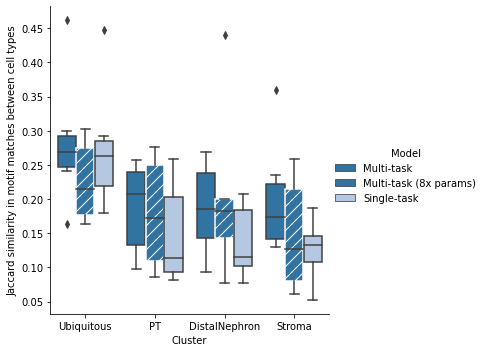

In [20]:
cmap = plt.get_cmap("tab20")
g = sns.catplot(data=aggregated_results, x="Cluster", hue="Model", y="Jaccard similarity in motif matches between cell types", 
            kind="box", aspect=1, palette=[cmap(0), cmap(0), cmap(1)])
for j in [3, 7, 10, 13]:
        g.axes[0][0].patches[j].set_hatch('//')
        g.axes[0][0].patches[j].set_edgecolor("white")
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_tfmodsico_single_multitask_high_capacity.pdf",
                dpi=300)

In [35]:
model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"
model = "train__multitask__all_sequences"
clusters = ["cluster_open_500bp", "cluster_myeloid_resting_500bp", "cluster_nk_resting_500bp", "cluster_T_resting_500bp"]
targets = ["DCmye", "TCD8EM", "NKim"]
target_inds = [3, 5, 21]
qval_thresh= 0.05
n = 6104

multitask_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))), 
                                 columns=clusters)
for rep in reps:
    for cluster in clusters:
        for i, ti in enumerate(target_inds):
            modisco_results = pd.read_html(f"{model_dir}/{model}__{rep}/modisco_results_{cluster}_{n}_ti_{ti}/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            multitask_results.loc[(targets[i], rep), cluster] = significant_tf_matches

            high_capacity_multitask_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))),
                                               columns=clusters)
model = "train__multitask_8x_params_same_layers__all_sequences"
for rep in reps:
    for cluster in clusters:
        for i, ti in enumerate(target_inds):
            modisco_results = pd.read_html(f"{model_dir}/{model}__{rep}/modisco_results_{cluster}_{n}_ti_{ti}/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            high_capacity_multitask_results.loc[(targets[i], rep), cluster] = significant_tf_matches

single_task_results = pd.DataFrame([], index=pd.MultiIndex.from_tuples(list(itertools.product(targets, reps))),
                                   columns=clusters)
model = "train__single_task__all_sequences"
for rep in reps:
    for cluster in clusters:
        for target in targets:
            modisco_results = pd.read_html(f"{model_dir}/train__single_task__{target}__all_sequences__{rep}/modisco_results_{cluster}_{n}_ti_0/motifs.html")[0]
            significant_tf_matches = np.concatenate([modisco_results[modisco_results[f"qval{i}"] < qval_thresh][f"match{i}"].values
                                                     for i in range(3)])
            single_task_results.loc[(target, rep), cluster] = significant_tf_matches

In [36]:
def jaccard(a, b):
    return len(set(a).intersection(set(b)))/len(set(a).union(set(b)))

aggregated_results = pd.DataFrame([])

for cluster in clusters:
    for i in range(len(targets)):
        for j in range(i+1, len(targets)):
            target_a = targets[i]
            target_b = targets[j]
            js = jaccard(multitask_results.loc[(target_a, 1), cluster], 
                         multitask_results.loc[(target_b, 1), cluster])
            aggregated_results = aggregated_results.append({"Model": "Multi-task",
                                                           "Cluster": cluster.split("_")[1],
                                                           "Jaccard similarity in motif matches between cell types": js,
                                                           "Target A": target_a,
                                                           "Target B": target_b}, ignore_index=True)
            
            js = jaccard(high_capacity_multitask_results.loc[(target_a, 1), cluster], 
                         high_capacity_multitask_results.loc[(target_b, 1), cluster])
            aggregated_results = aggregated_results.append({"Model": "Multi-task (8x params)",
                                                           "Cluster": cluster.split("_")[1],
                                                           "Jaccard similarity in motif matches between cell types": js,
                                                           "Target A": target_a,
                                                           "Target B": target_b}, ignore_index=True)
            
            js = jaccard(single_task_results.loc[(target_a, 1), cluster], 
                         single_task_results.loc[(target_b, 1), cluster])
            aggregated_results = aggregated_results.append({"Model": "Single-task",
                                                           "Cluster": cluster.split("_")[1],
                                                           "Jaccard similarity in motif matches between cell types": js,
                                                           "Target A": target_a,
                                                           "Target B": target_b}, ignore_index=True)

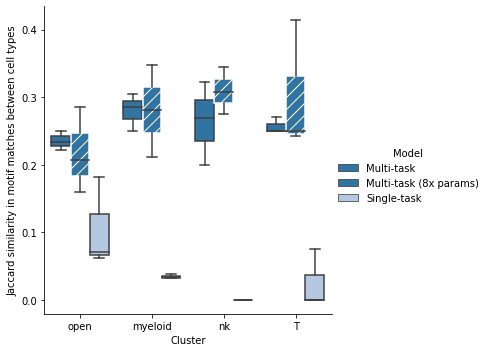

In [183]:
cmap = plt.get_cmap("tab20")
g = sns.catplot(data=aggregated_results, x="Cluster", hue="Model", y="Jaccard similarity in motif matches between cell types", 
            kind="box", aspect=1, palette=[cmap(0), cmap(0), cmap(1)])
for j in [3, 7, 10, 13]:
        g.axes[0][0].patches[j].set_hatch('//')
        g.axes[0][0].patches[j].set_edgecolor("white")
plt.savefig(f"{fig_dir}/supp_figs/calderon_et_al_tfmodsico_single_multitask_high_capacity.pdf",
                dpi=300)